In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import PCA

In [2]:
dataset = pd.read_csv('data.csv')
dataset = dataset.iloc[:, 1:-1]
dataset.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Do we need to normalize it?

In [3]:
from sklearn.preprocessing import LabelEncoder

diagnosis_unique, diagnosis_count = np.unique(dataset['diagnosis'].values, return_counts = True)

for i in range(diagnosis_unique.shape[0]):
    print (diagnosis_unique[i], ': ', diagnosis_count[0])

('B', ': ', 357)
('M', ': ', 357)


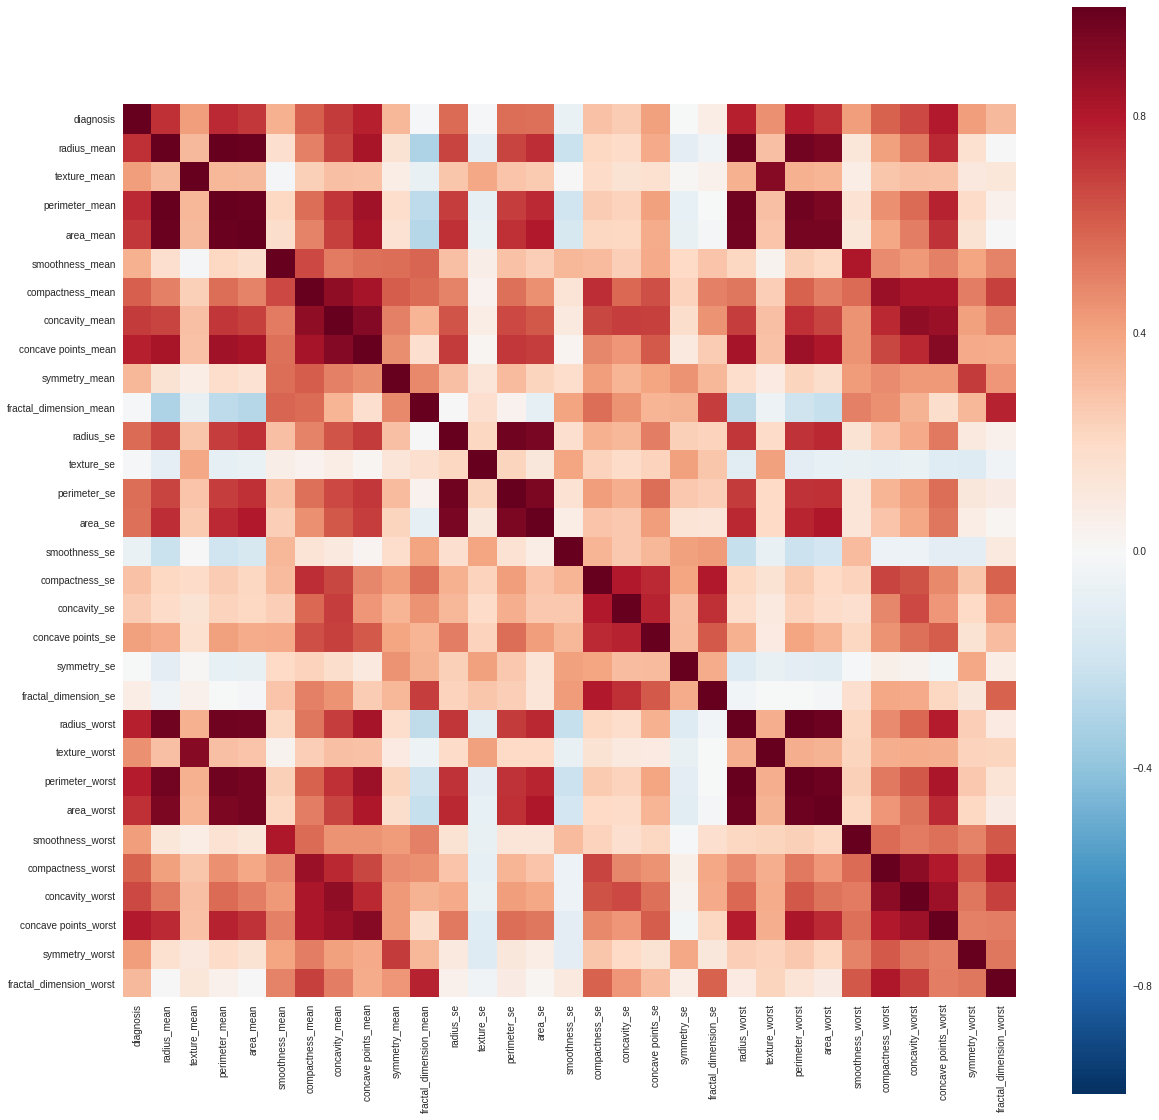

In [4]:
dataset['diagnosis'] = LabelEncoder().fit_transform(dataset['diagnosis'])
correlation = dataset.corr()
plt.figure(figsize = (20, 20))
sns.heatmap(correlation, vmax = 1, square = True, annot = False)
plt.show()

Now I want to analyse the component of our dataset

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

# change into numpy form for neural network use later    
dataset_matrix = dataset.values
dataset_matrix[:, 0] = LabelEncoder().fit_transform(dataset_matrix[:, 0])
label_matrix = dataset_matrix[:, 0]
dataset_matrix = dataset_matrix[:, 1:]

normalize_dataset_matrix = Normalizer().fit_transform(dataset_matrix)
std_normalize_dataset = StandardScaler().fit_transform(normalize_dataset_matrix)

mean_vec = np.mean(std_normalize_dataset, axis = 0)
cov_mat = (std_normalize_dataset - mean_vec).T.dot((std_normalize_dataset - mean_vec)) / (std_normalize_dataset.shape[0] - 1)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

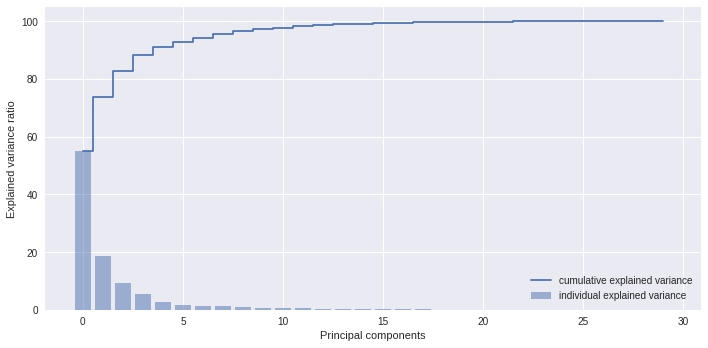

In [6]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse=True)
tot = sum(eig_vals)
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)
plt.figure(figsize = (10, 5))
plt.bar(range(len(eig_pairs)), var_exp, alpha = 0.5, align = 'center', label = 'individual explained variance')
plt.step(range(len(eig_pairs)), cum_var_exp, where = 'mid', label = 'cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

I will take 5 components, contain atleast 90% of dataset

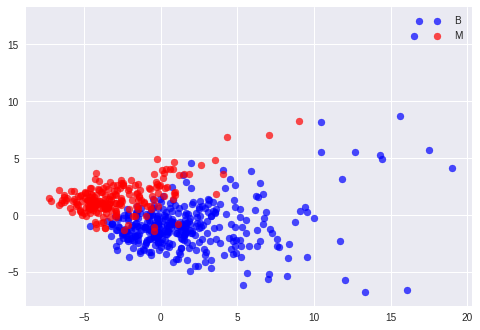

In [7]:
x_5d = PCA(n_components = 5).fit_transform(std_normalize_dataset)
colors = ['b', 'r']
for n, i in enumerate(np.unique(label_matrix)):
    plt.scatter(x_5d[:,0][label_matrix == i], x_5d[:,1][label_matrix == i], c = colors[n], label = diagnosis_unique[n], alpha = 0.7)
plt.legend()
plt.show()

Below I will create 3 types of feed-forward Neural Network:

All learning rate = 0.001, beta_l2 = 0.00005, beta1 = default, beta2 = default, batch_size = 32

input layer = [batch_size, x_shape]

first hidden layer = [x_shape, 512]

second hidden layer = [512, 256]

third hidden layer = [256, 128]

output layer = [128, y_shape]

1. 3 Hidden layers, all RELU as activation functions except softmax for last one, cross entropy for cost function, adaptive plus square root optimization stochastic gradient descent
2. 3 Hidden layers, dropout with 0.5, l2 norm, all RELU as activation functions except softmax for last one, cross entropy for cost function, adaptive plus square root optimization stochastic gradient descent
3. 3 Hidden layers, dropout with 0.5, l2 norm, batch normalization, all RELU as activation functions except softmax for last one, cross entropy for cost function, adaptive plus square root optimization stochastic gradient descent

But why I chose RELU as activation function? There is no upper boundary in RELU, a very simple function f(x) = max(x, 0)

![](http://cs231n.github.io/assets/nn1/relu.jpeg)

because it can go up until infinity, derivative of it is 1

In [8]:
class first_network:
    def __init__(self, learning_rate, x_shape, y_shape):
        self.X = tf.placeholder("float", [None, x_shape])
        self.Y = tf.placeholder("float", [None, y_shape])
        
        hidden1 = tf.Variable(tf.random_normal([x_shape, 512]))
        hidden2 = tf.Variable(tf.random_normal([512, 256]))
        hidden3 = tf.Variable(tf.random_normal([256, 128]))
        output = tf.Variable(tf.random_normal([128, y_shape]))

        hidden_bias1 = tf.Variable(tf.random_normal([512], stddev = 0.1))
        hidden_bias2 = tf.Variable(tf.random_normal([256], stddev = 0.1))
        hidden_bias3 = tf.Variable(tf.random_normal([128], stddev = 0.1))
        output_bias = tf.Variable(tf.random_normal([y_shape], stddev = 0.1))
        
        feedforward1 = tf.nn.relu(tf.matmul(self.X, hidden1) + hidden_bias1)
        feedforward2 = tf.nn.relu(tf.matmul(feedforward1, hidden2) + hidden_bias2)
        feedforward3 = tf.nn.relu(tf.matmul(feedforward2, hidden3) + hidden_bias3)
        
        self.logits = tf.matmul(feedforward3, output) + output_bias
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.Y, logits = self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
        correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

class second_network:
    def __init__(self, learning_rate, x_shape, y_shape, beta = 0.00005):
        self.X = tf.placeholder("float", [None, x_shape])
        self.Y = tf.placeholder("float", [None, y_shape])
        
        hidden1 = tf.Variable(tf.random_normal([x_shape, 512]))
        hidden2 = tf.Variable(tf.random_normal([512, 256]))
        hidden3 = tf.Variable(tf.random_normal([256, 128]))
        output = tf.Variable(tf.random_normal([128, y_shape]))

        hidden_bias1 = tf.Variable(tf.random_normal([512], stddev = 0.1))
        hidden_bias2 = tf.Variable(tf.random_normal([256], stddev = 0.1))
        hidden_bias3 = tf.Variable(tf.random_normal([128], stddev = 0.1))
        output_bias = tf.Variable(tf.random_normal([y_shape], stddev = 0.1))
        
        feedforward1 = tf.nn.dropout(tf.nn.relu(tf.matmul(self.X, hidden1) + hidden_bias1), 0.5)
        feedforward2 = tf.nn.dropout(tf.nn.relu(tf.matmul(feedforward1, hidden2) + hidden_bias2), 0.5)
        feedforward3 = tf.nn.dropout(tf.nn.relu(tf.matmul(feedforward2, hidden3) + hidden_bias3), 0.5)
        
        self.logits = tf.matmul(feedforward3, output) + output_bias
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.Y, logits = self.logits))
        self.cost += tf.nn.l2_loss(hidden1) * beta + tf.nn.l2_loss(hidden2) * beta + tf.nn.l2_loss(hidden3) * beta + tf.nn.l2_loss(output) * beta
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
        correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
class third_network:
    def __init__(self, learning_rate, x_shape, y_shape, beta = 0.00005):
        self.X = tf.placeholder("float", [None, x_shape])
        self.Y = tf.placeholder("float", [None, y_shape])
        
        hidden1 = tf.Variable(tf.random_normal([x_shape, 512]))
        hidden2 = tf.Variable(tf.random_normal([512, 256]))
        hidden3 = tf.Variable(tf.random_normal([256, 128]))
        output = tf.Variable(tf.random_normal([128, y_shape]))

        hidden_bias1 = tf.Variable(tf.random_normal([512], stddev = 0.1))
        hidden_bias2 = tf.Variable(tf.random_normal([256], stddev = 0.1))
        hidden_bias3 = tf.Variable(tf.random_normal([128], stddev = 0.1))
        output_bias = tf.Variable(tf.random_normal([y_shape], stddev = 0.1))
        
        feedforward1 = tf.nn.relu(tf.matmul(self.X, hidden1) + hidden_bias1)
        feedforward1 = tf.nn.dropout(tf.layers.batch_normalization(feedforward1), 0.5)
        feedforward2 = tf.nn.relu(tf.matmul(feedforward1, hidden2) + hidden_bias2)
        feedforward2 = tf.nn.dropout(tf.layers.batch_normalization(feedforward2), 0.5)
        feedforward3 = tf.nn.relu(tf.matmul(feedforward2, hidden3) + hidden_bias3)
        feedforward3 = tf.nn.dropout(tf.layers.batch_normalization(feedforward3), 0.5)
        
        self.logits = tf.matmul(feedforward3, output) + output_bias
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.Y, logits = self.logits))
        self.cost += tf.nn.l2_loss(hidden1) * beta + tf.nn.l2_loss(hidden2) * beta + tf.nn.l2_loss(hidden3) * beta + tf.nn.l2_loss(output) * beta
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
        correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [9]:
def train(model, x_train, y_train, x_test, y_test, epoch, batch):
    LOST, ACC_TRAIN, ACC_TEST = [], [], []
    for i in range(epoch):
        loss, acc_train = 0, 0
        for n in range(0, (x_train.shape[0] // batch) * batch, batch):
            onehot = np.zeros((batch, np.unique(y_train).shape[0]))
            
            # change to one-hot for cross entropy
            for k in range(batch):
                onehot[k, int(y_train[n + k])] = 1.0
            
            cost, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X : x_train[n: n + batch, :], model.Y : onehot})
            acc_train += sess.run(model.accuracy, feed_dict = {model.X : x_train[n: n + batch, :], model.Y : onehot})
            loss += cost
            
        loss /= (x_train.shape[0] // batch)
        acc_train /= (x_train.shape[0] // batch)
        LOST.append(loss); ACC_TRAIN.append(acc_train)
        
        print ('epoch: ', i + 1, ', loss: ', loss, ', accuracy: ', acc_train)
        
        onehot = np.zeros((y_test.shape[0], np.unique(y_test).shape[0]))
        
        # change to one-hot for cross entropy
        for k in range(y_test.shape[0]):
            onehot[k, int(y_test[k])] = 1.0
            
        testing_acc, logits = sess.run([model.accuracy, tf.cast(tf.argmax(model.logits, 1), tf.int32)], feed_dict = {model.X : x_test, model.Y : onehot})
        
        print ('testing accuracy: ', testing_acc)
        print (metrics.classification_report(y_test, logits, target_names = diagnosis_unique))
        
        ACC_TEST.append(testing_acc)
        
    plt.subplot(1, 2, 1)
    x_component = [i for i in range(len(LOST))]
    plt.plot(x_component, LOST)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.subplot(1, 2, 2)
    plt.plot(x_component, ACC_TRAIN, label = 'train accuracy')
    plt.plot(x_component, ACC_TEST, label = 'test accuracy')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

We will try to train the model with default dataset, no normalization applied

In [10]:
EPOCH = 10
BATCH = 32
LEARNING_RATE = 0.001

from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(dataset_matrix, label_matrix, test_size = 0.2)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


First neural model trained with un-normalized dataset

('epoch: ', 1, ', loss: ', 178666.09221540179, ', accuracy: ', 0.5089285714285714)
('testing accuracy: ', 0.79824561)
             precision    recall  f1-score   support

          B       0.78      0.99      0.87        81
          M       0.92      0.33      0.49        33

avg / total       0.82      0.80      0.76       114

('epoch: ', 2, ', loss: ', 21647.225027901786, ', accuracy: ', 0.796875)
('testing accuracy: ', 0.92105263)
             precision    recall  f1-score   support

          B       0.90      1.00      0.95        81
          M       1.00      0.73      0.84        33

avg / total       0.93      0.92      0.92       114

('epoch: ', 3, ', loss: ', 8733.0705217633931, ', accuracy: ', 0.8861607142857143)
('testing accuracy: ', 0.90350878)
             precision    recall  f1-score   support

          B       0.93      0.94      0.93        81
          M       0.84      0.82      0.83        33

avg / total       0.90      0.90      0.90       114

('epoch: ',

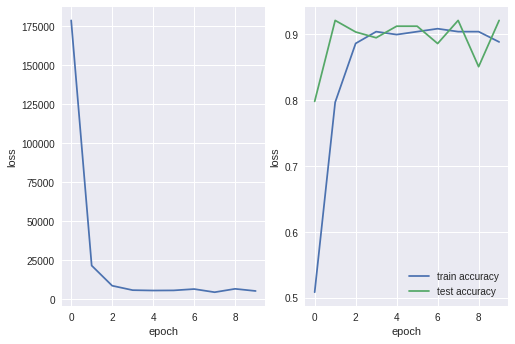

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = first_network(LEARNING_RATE, X_train.shape[1], diagnosis_unique.shape[0])
sess.run(tf.global_variables_initializer())
train(model, X_train, Y_train, X_test, Y_test, EPOCH, BATCH)

This is good! validation also good!

('epoch: ', 1, ', loss: ', 1837121.3973214286, ', accuracy: ', 0.5022321428571429)
('testing accuracy: ', 0.48245615)
             precision    recall  f1-score   support

          B       0.71      0.46      0.56        81
          M       0.29      0.55      0.38        33

avg / total       0.59      0.48      0.51       114

('epoch: ', 2, ', loss: ', 1948813.7410714286, ', accuracy: ', 0.5245535714285714)
('testing accuracy: ', 0.5350877)
             precision    recall  f1-score   support

          B       0.76      0.51      0.61        81
          M       0.33      0.61      0.43        33

avg / total       0.64      0.54      0.56       114

('epoch: ', 3, ', loss: ', 1614097.9441964286, ', accuracy: ', 0.5446428571428571)
('testing accuracy: ', 0.47368422)
             precision    recall  f1-score   support

          B       0.69      0.47      0.56        81
          M       0.27      0.48      0.35        33

avg / total       0.57      0.47      0.50       114

('

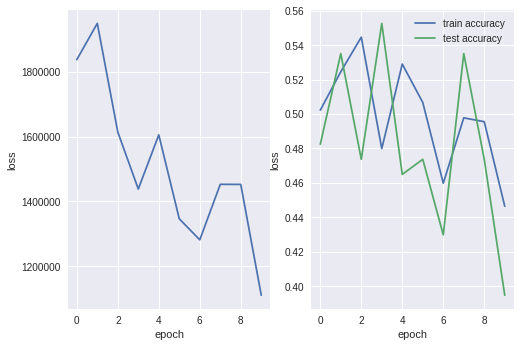

In [12]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = second_network(LEARNING_RATE, X_train.shape[1], diagnosis_unique.shape[0])
sess.run(tf.global_variables_initializer())
train(model, X_train, Y_train, X_test, Y_test, EPOCH, BATCH)

Oh no! what happen! This is caused by the dropout and penalty L2 square root. It preventing the neural network become over-fitted and high variance for the dataset, but the accuracy during validation also sucks!

('epoch: ', 1, ', loss: ', 2031643.544642857, ', accuracy: ', 0.49107142857142855)
('testing accuracy: ', 0.47368422)
             precision    recall  f1-score   support

          B       0.72      0.42      0.53        81
          M       0.30      0.61      0.40        33

avg / total       0.60      0.47      0.49       114

('epoch: ', 2, ', loss: ', 1480771.625, ', accuracy: ', 0.484375)
('testing accuracy: ', 0.4649123)
             precision    recall  f1-score   support

          B       0.73      0.40      0.51        81
          M       0.30      0.64      0.41        33

avg / total       0.60      0.46      0.48       114

('epoch: ', 3, ', loss: ', 1813077.267857143, ', accuracy: ', 0.4799107142857143)
('testing accuracy: ', 0.50877196)
             precision    recall  f1-score   support

          B       0.80      0.41      0.54        81
          M       0.34      0.76      0.47        33

avg / total       0.67      0.51      0.52       114

('epoch: ', 4, ', lo

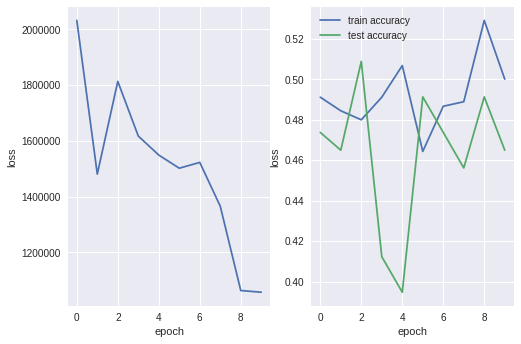

In [13]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = third_network(LEARNING_RATE, X_train.shape[1], diagnosis_unique.shape[0])
sess.run(tf.global_variables_initializer())
train(model, X_train, Y_train, X_test, Y_test, EPOCH, BATCH)

dropping out some nodes connection totally not a good idea for this dataset!

How about we train on normalized dataset?

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(normalize_dataset_matrix, label_matrix, test_size = 0.2)

('epoch: ', 1, ', loss: ', 190.02143369402205, ', accuracy: ', 0.5379464285714286)
('testing accuracy: ', 0.69298244)
             precision    recall  f1-score   support

          B       0.69      1.00      0.82        79
          M       0.00      0.00      0.00        35

avg / total       0.48      0.69      0.57       114

('epoch: ', 2, ', loss: ', 43.633389472961426, ', accuracy: ', 0.6540178571428571)
('testing accuracy: ', 0.81578946)
             precision    recall  f1-score   support

          B       0.84      0.91      0.87        79
          M       0.75      0.60      0.67        35

avg / total       0.81      0.82      0.81       114

('epoch: ', 3, ', loss: ', 15.470594559397016, ', accuracy: ', 0.7700892857142857)
('testing accuracy: ', 0.78947371)
             precision    recall  f1-score   support

          B       0.88      0.81      0.84        79
          M       0.63      0.74      0.68        35

avg / total       0.80      0.79      0.79       114

(

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('epoch: ', 5, ', loss: ', 6.6362419513586373, ', accuracy: ', 0.8883928571428571)
('testing accuracy: ', 0.84210527)
             precision    recall  f1-score   support

          B       0.84      0.96      0.89        79
          M       0.87      0.57      0.69        35

avg / total       0.85      0.84      0.83       114

('epoch: ', 6, ', loss: ', 5.8162013292312622, ', accuracy: ', 0.8727678571428571)
('testing accuracy: ', 0.85964912)
             precision    recall  f1-score   support

          B       0.84      0.99      0.91        79
          M       0.95      0.57      0.71        35

avg / total       0.87      0.86      0.85       114

('epoch: ', 7, ', loss: ', 5.2400489151477814, ', accuracy: ', 0.8928571428571429)
('testing accuracy: ', 0.86842108)
             precision    recall  f1-score   support

          B       0.85      0.99      0.91        79
          M       0.95      0.60      0.74        35

avg / total       0.88      0.87      0.86       114

(

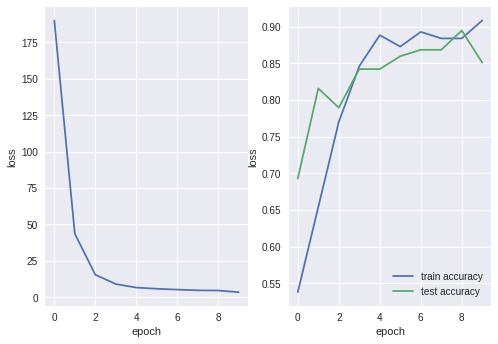

In [15]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = first_network(LEARNING_RATE, X_train.shape[1], diagnosis_unique.shape[0])
sess.run(tf.global_variables_initializer())
train(model, X_train, Y_train, X_test, Y_test, EPOCH, BATCH)

Our first model is very good enough!

('epoch: ', 1, ', loss: ', 2010.1989092145648, ', accuracy: ', 0.5111607142857143)
('testing accuracy: ', 0.47368422)
             precision    recall  f1-score   support

          B       0.67      0.47      0.55        79
          M       0.29      0.49      0.36        35

avg / total       0.55      0.47      0.49       114

('epoch: ', 2, ', loss: ', 1522.1168300083705, ', accuracy: ', 0.5044642857142857)
('testing accuracy: ', 0.45614034)
             precision    recall  f1-score   support

          B       0.63      0.53      0.58        79
          M       0.21      0.29      0.24        35

avg / total       0.50      0.46      0.47       114

('epoch: ', 3, ', loss: ', 1378.1690325055804, ', accuracy: ', 0.5401785714285714)
('testing accuracy: ', 0.56140351)
             precision    recall  f1-score   support

          B       0.72      0.59      0.65        79
          M       0.35      0.49      0.40        35

avg / total       0.61      0.56      0.58       114

(

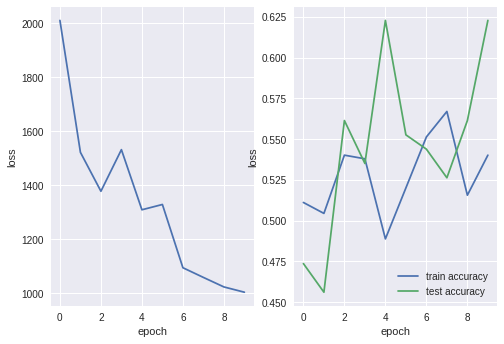

In [16]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = second_network(LEARNING_RATE, X_train.shape[1], diagnosis_unique.shape[0])
sess.run(tf.global_variables_initializer())
train(model, X_train, Y_train, X_test, Y_test, EPOCH, BATCH)

Bad as un-normalized dataset. So let's continue with third model

('epoch: ', 1, ', loss: ', 2123.9415021623886, ', accuracy: ', 0.5647321428571429)
('testing accuracy: ', 0.54385966)
             precision    recall  f1-score   support

          B       0.71      0.58      0.64        79
          M       0.33      0.46      0.38        35

avg / total       0.59      0.54      0.56       114

('epoch: ', 2, ', loss: ', 1870.0168675013952, ', accuracy: ', 0.5357142857142857)
('testing accuracy: ', 0.55263156)
             precision    recall  f1-score   support

          B       0.71      0.61      0.65        79
          M       0.33      0.43      0.37        35

avg / total       0.59      0.55      0.57       114

('epoch: ', 3, ', loss: ', 1759.0216500418526, ', accuracy: ', 0.5625)
('testing accuracy: ', 0.56140351)
             precision    recall  f1-score   support

          B       0.71      0.62      0.66        79
          M       0.33      0.43      0.38        35

avg / total       0.59      0.56      0.57       114

('epoch: ', 4

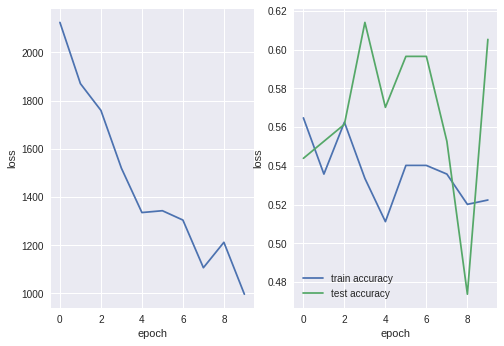

In [17]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = third_network(LEARNING_RATE, X_train.shape[1], diagnosis_unique.shape[0])
sess.run(tf.global_variables_initializer())
train(model, X_train, Y_train, X_test, Y_test, EPOCH, BATCH)

Nope, nope, totally a nope. We reject our second and third model? But why it happens like that for second and third model? I thought dropout and l2 square root normalization is to help us to prevent overfitted? Even our first model is very good trading between bias and variance, validation also got good accuracy.

Now let's visualize how our neural network regressed the decision

('epoch: ', 1, ', loss: ', 2460.1134098597936, ', accuracy: ', 0.65625)
('testing accuracy: ', 0.78070176)
             precision    recall  f1-score   support

          B       0.86      0.75      0.80        67
          M       0.70      0.83      0.76        47

avg / total       0.79      0.78      0.78       114

('epoch: ', 2, ', loss: ', 398.32434953962053, ', accuracy: ', 0.859375)
('testing accuracy: ', 0.92105263)
             precision    recall  f1-score   support

          B       0.98      0.88      0.93        67
          M       0.85      0.98      0.91        47

avg / total       0.93      0.92      0.92       114

('epoch: ', 3, ', loss: ', 184.86754008701868, ', accuracy: ', 0.8861607142857143)
('testing accuracy: ', 0.91228068)
             precision    recall  f1-score   support

          B       0.95      0.90      0.92        67
          M       0.86      0.94      0.90        47

avg / total       0.92      0.91      0.91       114

('epoch: ', 4, ', loss

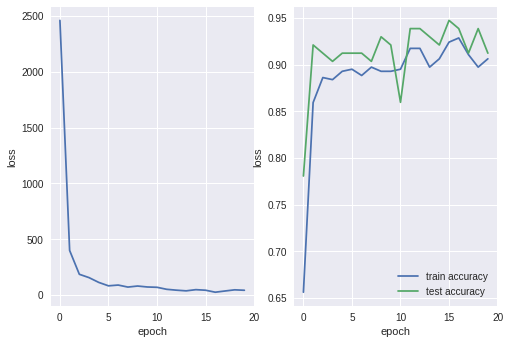

In [18]:
x_2d = x_5d[:, :2]
X_train, X_test, Y_train, Y_test = train_test_split(x_2d, label_matrix, test_size = 0.2)

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = first_network(LEARNING_RATE, X_train.shape[1], diagnosis_unique.shape[0])
sess.run(tf.global_variables_initializer())
train(model, X_train, Y_train, X_test, Y_test, 20, BATCH)

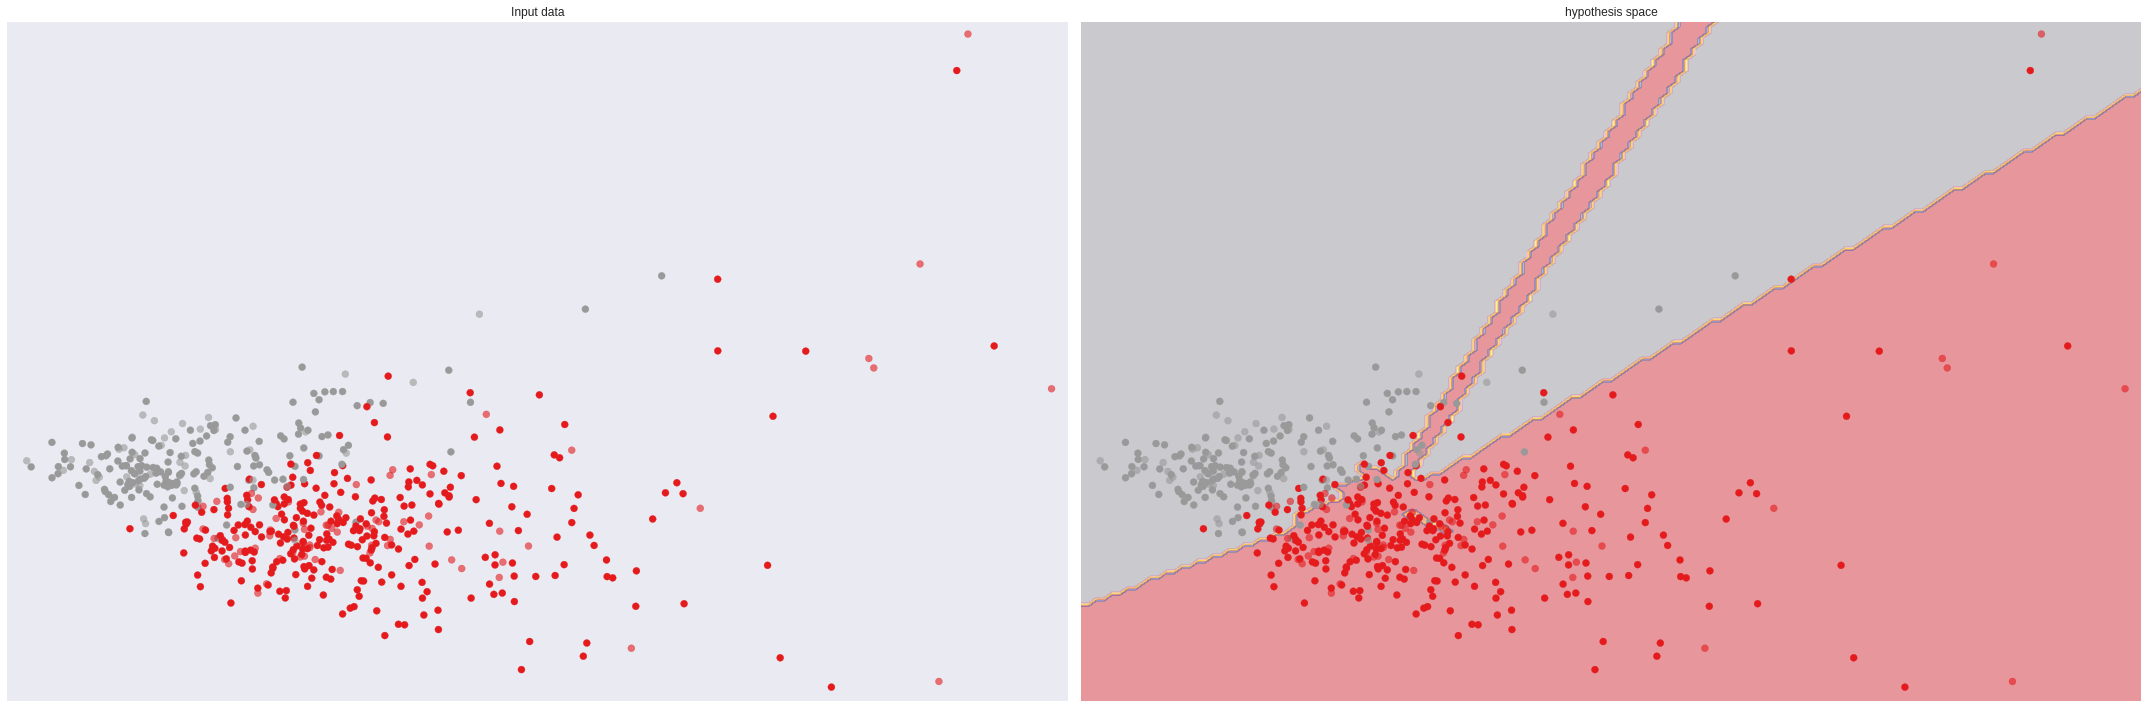

In [19]:
plt.figure(figsize = (30, 10))
x_min, x_max = x_2d[:, 0].min() - 0.5, x_2d[:, 0].max() + 0.5
y_min, y_max = x_2d[:, 1].min() - 0.5, x_2d[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2), np.arange(y_min, y_max, 0.2))

ax = plt.subplot(1, 2, 1)
ax.set_title('Input data')
ax.scatter(X_train[:, 0], X_train[:, 1], c = Y_train, cmap = plt.cm.Set1, label = diagnosis_unique)
ax.scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = plt.cm.Set1, alpha = 0.6)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())


ax = plt.subplot(1, 2, 2)
contour = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
Z = sess.run(tf.nn.softmax(model.logits), feed_dict = {model.X: contour})
temp_answer = []
for q in range(Z.shape[0]):
    temp_answer.append(np.argmax(Z[q]))
Z = np.array(temp_answer)
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap = plt.cm.Set1, alpha = 0.4)
ax.scatter(X_train[:, 0], X_train[:, 1], c = Y_train, cmap = plt.cm.Set1, label = diagnosis_unique)
ax.scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = plt.cm.Set1, alpha = 0.6)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('hypothesis space')
plt.tight_layout()
plt.show()